# LSTM Remaining Useful Life (RUL) Model Pipeline
This notebook builds a complete pipeline for training an LSTM model on the CMAPSS FD001 dataset.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('train_FD001.csv')
df.head()

/Users/evethullen/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


,unit,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [ ]:
# Compute RUL
max_cycle = df.groupby('unit')['cycle'].max().reset_index().rename(columns={'cycle': 'max_cycle'})
max_cycle
#df = df.merge(max_cycle, on='unit', how='left')

#df['RUL'] = df['max_cycle'] - df['cycle']
#df[['unit','cycle','RUL']].head()


,unit,max_cycle
0,1,192
1,2,287
2,3,179
3,4,189
4,5,269
...,...,...
95,96,336
96,97,202
97,98,156
98,99,185


In [ ]:
# Feature selection
exclude = {'unit','cycle','RUL','max_cycle'}
feature_cols = [c for c in df.columns if c not in exclude]
features = df[feature_cols].values
labels = df['RUL'].values

# Scaling
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)
scaled_df = pd.DataFrame(scaled_features, columns=feature_cols)
scaled_df['RUL'] = labels
scaled_df['unit'] = df['unit']
scaled_df['cycle'] = df['cycle']
scaled_df.head()

,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,...,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,max_cycle_x,max_cycle_y,RUL,unit,cycle
0,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,1.0,0.726248,...,0.333333,0.0,0.0,0.713178,0.724662,0.273504,0.273504,191,1,1
1,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,1.0,0.628019,...,0.333333,0.0,0.0,0.666667,0.731014,0.273504,0.273504,190,1,2
2,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,1.0,0.710145,...,0.166667,0.0,0.0,0.627907,0.621375,0.273504,0.273504,189,1,3
3,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,1.0,0.740741,...,0.333333,0.0,0.0,0.573643,0.662386,0.273504,0.273504,188,1,4
4,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,1.0,0.668277,...,0.416667,0.0,0.0,0.589147,0.704502,0.273504,0.273504,187,1,5


In [ ]:
# Sequence building
TIME_STEPS = 50
X_list, y_list = [], []
for uid, group in scaled_df.groupby('unit'):
    g = group[feature_cols + ['RUL']].values
    if len(g) >= TIME_STEPS:
        for i in range(len(g) - TIME_STEPS + 1):
            X_list.append(g[i:i+TIME_STEPS, :-1])  # sensors
            y_list.append(g[i+TIME_STEPS-1, -1])   # RUL at end

X = np.array(X_list)
y = np.array(y_list)
X.shape, y.shape

((15731, 50, 26), (15731,))

In [ ]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((12584, 50, 26), (3147, 50, 26))

In [ ]:
# Build LSTM model
tf.keras.backend.clear_session()
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(loss='mse', optimizer=Adam(1e-3), metrics=['mae'])
model.summary()

/Users/evethullen/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 64)         │        23,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,801 (143.75 KB)

 Trainable params: 36,801 (143.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
197/197 - 10s - 49ms/step - loss: 6307.0132 - mae: 61.1388 - val_loss: 3430.6516 - val_mae: 45.9774
Epoch 2/8
197/197 - 6s - 33ms/step - loss: 3380.3662 - mae: 46.6538 - val_loss: 3257.8079 - val_mae: 46.0498
Epoch 3/8
197/197 - 6s - 32ms/step - loss: 3362.4065 - mae: 46.9064 - val_loss: 3255.5920 - val_mae: 45.9834
Epoch 4/8
197/197 - 6s - 33ms/step - loss: 3357.7178 - mae: 46.8545 - val_loss: 3258.5024 - val_mae: 46.0675
Epoch 5/8
197/197 - 6s - 33ms/step - loss: 3349.3967 - mae: 46.8069 - val_loss: 3253.9297 - val_mae: 45.8888
Epoch 6/8
197/197 - 7s - 35ms/step - loss: 3351.0635 - mae: 46.7239 - val_loss: 3253.8735 - val_mae: 45.8903
Epoch 7/8
197/197 - 7s - 33ms/step - loss: 3335.2798 - mae: 46.6039 - val_loss: 3240.7788 - val_mae: 45.8701
Epoch 8/8
197/197 - 7s - 37ms/step - loss: 1904.7994 - mae: 32.0419 - val_loss: 851.3917 - val_mae: 19.1468


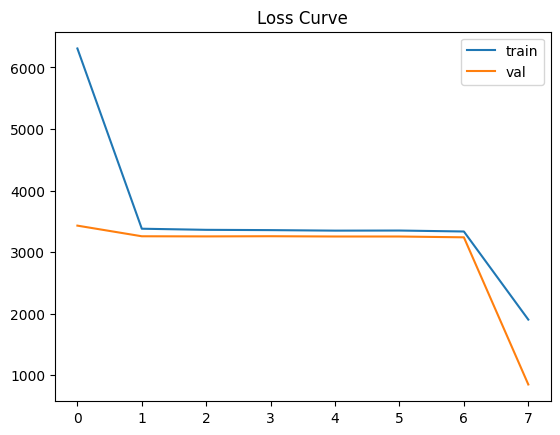

In [ ]:
# Train
history = model.fit(X_train, y_train, epochs=8, batch_size=64,
                    validation_data=(X_test, y_test), verbose=2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.title('Loss Curve')
plt.show()

In [ ]:
# Prediction Pairs
# 	If predicted RUL ≈ true RUL, the model is accurate.
# 	•	If predicted > true, the model is too optimistic (thinks engine lasts longer).
# 	•	If predicted < true, it is too conservative.
#  In practice, a ±10 cycle error is normal for FD001 because sensor noise is real.

# preds_int = preds.astype(int)
# list(zip(y_test[:20], preds_int))

# Get predictions
preds = model.predict(X_test[:200]).flatten()

# Convert predictions to normal Python integers
preds_int = [int(round(p)) for p in preds]
# Convert true y_test values to normal Python integers
true_int = [int(round(float(v))) for v in y_test[:200]]

# Combine into clean pairs
pairs = list(zip(true_int, preds_int))

pairs[:10]

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


[(133, 146),
 (3, 5),
 (96, 47),
 (220, 116),
 (54, 88),
 (17, 20),
 (81, 88),
 (97, 115),
 (29, 18),
 (100, 116)]

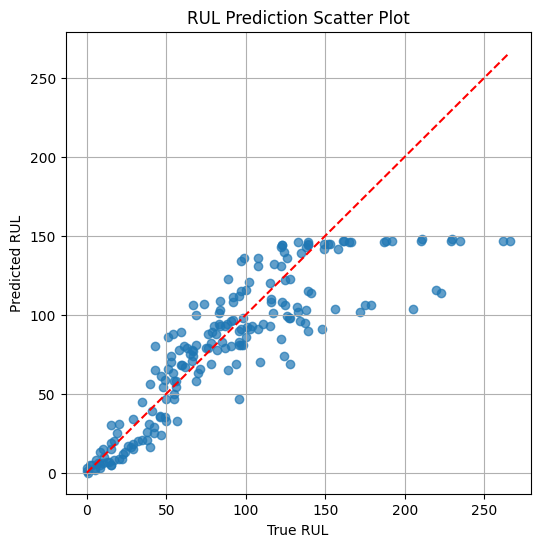

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(true_int, preds_int, alpha=0.7)
plt.plot([0, max(true_int)], [0, max(true_int)], 'r--')  # ideal line

plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("RUL Prediction Scatter Plot")
plt.grid(True)
plt.show()

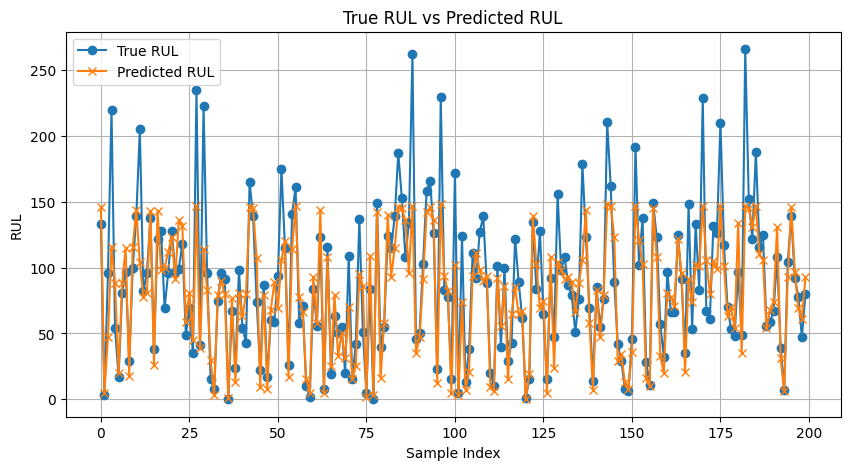

In [ ]:
# Create a DataFrame for plotting
df_plot = pd.DataFrame({
    "True_RUL": true_int,
    "Pred_RUL": preds_int
})

plt.figure(figsize=(10,5))
plt.plot(df_plot["True_RUL"].values, label="True RUL", marker='o')
plt.plot(df_plot["Pred_RUL"].values, label="Predicted RUL", marker='x')

plt.title("True RUL vs Predicted RUL")
plt.xlabel("Sample Index")
plt.ylabel("RUL")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:


# -------- 7. evaluate --------
# Typical MAE for FD001 using a basic LSTM:
# 	•	MAE < 20 → Excellent
# 	•	MAE 20–30 → Good
# 	•	MAE 30–50 → Acceptable
# 	•	MAE > 50 → Poor model performance
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error

pred = model.predict(X_test).flatten()
mae = mean_absolute_error(y_test, pred)
rmse = math.sqrt(mean_squared_error(y_test, pred))
print(f"Test MAE: {mae:.3f}, RMSE: {rmse:.3f}")

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Test MAE: 19.147, RMSE: 29.179


In [ ]:
# Section 2: Feature Importance Analysis

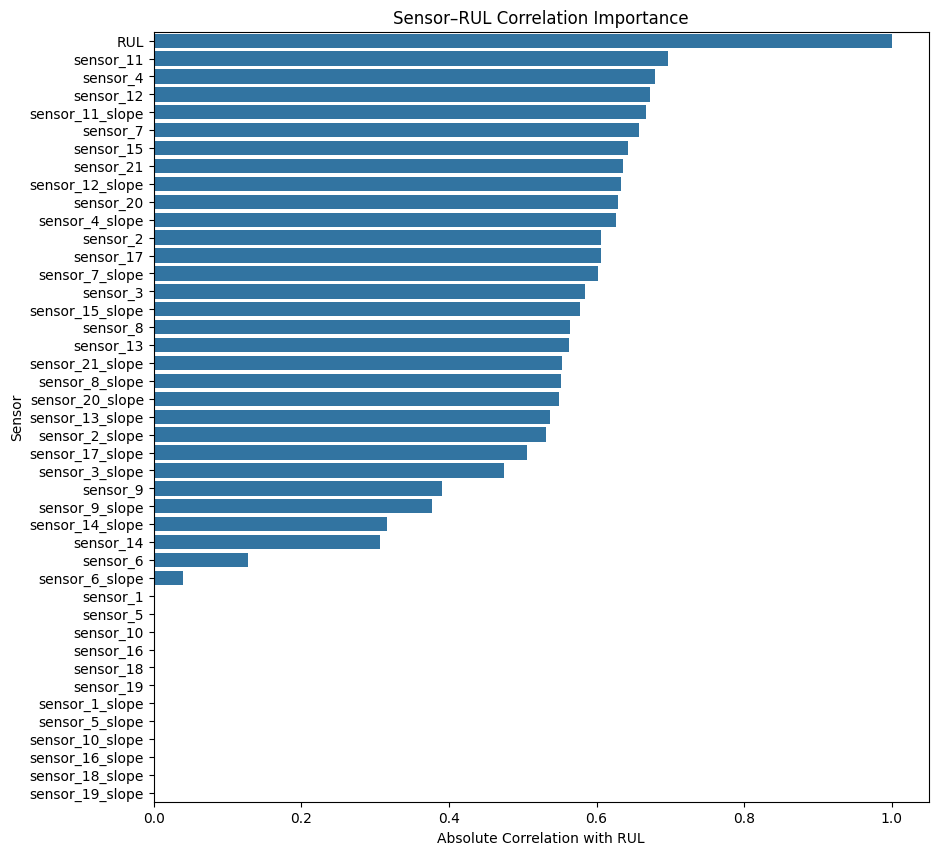

RUL                1.000000
sensor_11          0.696228
sensor_4           0.678948
sensor_12          0.671983
sensor_11_slope    0.667071
sensor_7           0.657223
sensor_15          0.642667
sensor_21          0.635662
sensor_12_slope    0.632854
sensor_20          0.629428
sensor_4_slope     0.626834
sensor_2           0.606484
sensor_17          0.606154
sensor_7_slope     0.601404
sensor_3           0.584520
sensor_15_slope    0.578101
sensor_8           0.563968
sensor_13          0.562569
sensor_21_slope    0.553328
sensor_8_slope     0.551737
sensor_20_slope    0.549358
sensor_13_slope    0.536631
sensor_2_slope     0.530996
sensor_17_slope    0.506075
sensor_3_slope     0.474543
sensor_9           0.390102
sensor_9_slope     0.376492
sensor_14_slope    0.316656
sensor_14          0.306769
sensor_6           0.128348
sensor_6_slope     0.040205
sensor_1                NaN
sensor_5                NaN
sensor_10               NaN
sensor_16               NaN
sensor_18           

In [ ]:
# #1 Correlation with RUL (Fast Diagnostic)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sensor_cols = [c for c in df.columns if "sensor" in c]

corrs = df[sensor_cols + ["RUL"]].corr()["RUL"].abs().sort_values(ascending=False)

plt.figure(figsize=(10,10))
sns.barplot(x=corrs.values, y=corrs.index)
plt.title("Sensor–RUL Correlation Importance")
plt.xlabel("Absolute Correlation with RUL")
plt.ylabel("Sensor")
plt.show()

print(corrs)

In [ ]:
#1 Correlation with RUL (Fast Diagnostic)
corr = df.corr()['RUL'].abs().sort_values(ascending=False)
corr.head(15)

RUL                1.000000
cycle              0.736241
sensor_11          0.696228
sensor_4           0.678948
sensor_12          0.671983
sensor_11_slope    0.667071
sensor_7           0.657223
sensor_15          0.642667
sensor_21          0.635662
sensor_12_slope    0.632854
sensor_20          0.629428
sensor_4_slope     0.626834
sensor_2           0.606484
sensor_17          0.606154
sensor_7_slope     0.601404
Name: RUL, dtype: float64

In [ ]:
# 2: Time Series Stability / Degradation Analysis

# Some sensors don’t change at all (flat line) → useless
# Some sensors vary but not related to failure → noise
# Some sensors show consistent degradation → extremely important

# Identify sensors with clear downward or upward trends

import numpy as np

slopes = {}

for s in sensor_cols:
    slopes[s] = np.polyfit(df["cycle"], df[s], 1)[0]

pd.Series(slopes).sort_values()

	# •	Large negative slope = strong degradation
	# •	Large positive slope = increasing stress/temp etc → can also be important
	# •	Values near zero = poor signal

sensor_7          -7.657243e-03
sensor_12         -6.546159e-03
sensor_20         -1.531381e-03
sensor_21         -9.208160e-04
sensor_18         -2.832202e-14
sensor_1          -6.293783e-15
sensor_19         -1.130914e-15
sensor_5          -1.598031e-16
sensor_10         -1.997538e-17
sensor_16         -4.081509e-19
sensor_6           2.137086e-06
sensor_15          3.205283e-04
sensor_8           4.905196e-04
sensor_13          4.985836e-04
sensor_11          2.459838e-03
sensor_2           3.992078e-03
sensor_17          1.274867e-02
sensor_3           4.841714e-02
sensor_4           8.161283e-02
sensor_14          1.025589e-01
sensor_9           1.423438e-01
sensor_1_slope              NaN
sensor_2_slope              NaN
sensor_3_slope              NaN
sensor_4_slope              NaN
sensor_5_slope              NaN
sensor_6_slope              NaN
sensor_7_slope              NaN
sensor_8_slope              NaN
sensor_9_slope              NaN
sensor_10_slope             NaN
sensor_1

In [ ]:
# 3. Permutation Importance
import numpy as np
from sklearn.metrics import mean_absolute_error

def permutation_importance_lstm(model, X_val, y_val, feature_names):
    baseline_pred = model.predict(X_val)
    baseline_mae = mean_absolute_error(y_val, baseline_pred)

    importance = {}

    for i, name in enumerate(feature_names):
        X_shuffled = X_val.copy()

        # shuffle only one feature across all time steps
        X_shuffled[:,:,i] = np.random.permutation(X_shuffled[:,:,i].flatten()).reshape(X_val[:,:,i].shape)

        pred = model.predict(X_shuffled)
        mae = mean_absolute_error(y_val, pred)
        importance[name] = mae - baseline_mae

    return sorted(importance.items(), key=lambda x: x[1], reverse=True)



important_sensors = permutation_importance_lstm(model, X_test, y_test, feature_cols)
important_sensors[:10]

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
99/99 ━━━━━━━━━━━━━━━━━━━

[('sensor_9', np.float64(0.7794530306557164)),
 ('sensor_14', np.float64(0.7261642932910775)),
 ('max_cycle_y', np.float64(0.6512744969267814)),
 ('max_cycle_x', np.float64(0.4230473785029929)),
 ('op_setting_3', np.float64(0.0)),
 ('sensor_1', np.float64(0.0)),
 ('sensor_5', np.float64(0.0)),
 ('sensor_10', np.float64(0.0)),
 ('sensor_16', np.float64(0.0)),
 ('sensor_18', np.float64(0.0))]

In [ ]:
#4.PCA / Health Indicator Contribution
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(df[feature_cols])

importance = pd.Series(np.abs(pca.components_[0]), index=feature_cols)
importance.sort_values(ascending=False).head(10)

max_cycle_y    0.706521
max_cycle_x    0.706521
sensor_9       0.027918
sensor_14      0.027725
sensor_4       0.009179
sensor_3       0.004539
sensor_17      0.001097
sensor_7       0.001035
sensor_12      0.000855
sensor_2       0.000531
dtype: float64

In [ ]:
###### Section 3: Composite Degradation Indicator (CDI)


In [ ]:
key_sensors = ["sensor_9", "sensor_14", "sensor_4", "sensor_3", "sensor_17", "sensor_7"]

In [ ]:
#
weights = {
    'sensor_9': 0.027918,
    'sensor_14': 0.027725,
    'sensor_4': 0.009179,
    'sensor_3': 0.004539,
    'sensor_17': 0.001097
}

df["CDI_weighted"] = sum(df[s] * w for s, w in weights.items())

In [ ]:
df_norm = (df[key_sensors] - df[key_sensors].min()) / (df[key_sensors].max() - df[key_sensors].min())
df["HI_norm"] = df_norm.mean(axis=1)
df_norm

,sensor_9,sensor_14,sensor_11,sensor_4,sensor_12
0,0.109755,0.199608,0.369048,0.309757,0.633262
1,0.100242,0.162813,0.380952,0.352633,0.765458
2,0.140043,0.171793,0.250000,0.370527,0.795309
3,0.124518,0.174889,0.166667,0.331195,0.889126
4,0.149960,0.174734,0.255952,0.404625,0.746269
...,...,...,...,...,...
20626,0.196491,0.194344,0.726190,0.782917,0.170576
20627,0.194651,0.188668,0.708333,0.866475,0.211087
20628,0.198196,0.212148,0.738095,0.775321,0.281450
20629,0.233285,0.203065,0.916667,0.747468,0.208955


In [ ]:
# PCA-Based Health Index
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = df[key_sensors]

# Standardize (PCA works best on standardized data)
scaler_hi = StandardScaler()
X_scaled = scaler_hi.fit_transform(X)

# PCA
pca = PCA(n_components=1)
df["HI_pca"] = pca.fit_transform(X_scaled)

df["HI_pca"]

0       -1.171213
1       -1.551656
2       -1.841284
3       -2.590605
4       -1.505563
           ...   
20626    3.366770
20627    3.440851
20628    3.087642
20629    3.902500
20630    3.879537
Name: HI_pca, Length: 20631, dtype: float64

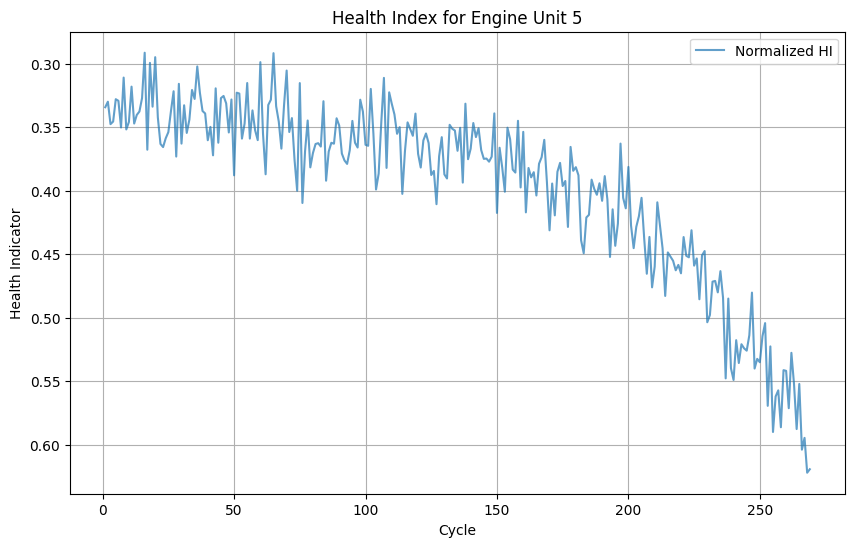

In [ ]:
import matplotlib.pyplot as plt

unit_id = 5
g = df[df["unit"] == unit_id]

plt.figure(figsize=(10,6))
#plt.plot(g["cycle"], g["HI_pca"], label="PCA Health Index")
#plt.plot(g["cycle"], g["CDI_weighted"], label="Weighted CDI", alpha=0.7)
plt.plot(g["cycle"], g["HI_norm"], label="Normalized HI", alpha=0.7)

plt.gca().invert_yaxis()        # health decreases over time
plt.title(f"Health Index for Engine Unit {unit_id}")
plt.xlabel("Cycle")
plt.ylabel("Health Indicator")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Add FFT indicators for these sensors

# compute FFT energy and FFT peak amplitude over a rolling window
#	•	For sensors: sensor_9, sensor_14, sensor_4, sensor_3, sensor_17
#	•	Add new columns like sensor_9_fft_energy, sensor_9_fft_peak, etc.


In [ ]:
import numpy as np

def fft_energy(x):
    """
    Sum of squared magnitudes of the FFT (a simple measure of signal power).
    x is a 1D numpy array (rolling window of one sensor).
    """
    # real FFT (only non-negative frequencies)
    f = np.fft.rfft(x)
    mag = np.abs(f)
    return float(np.sum(mag ** 2))

def fft_peak(x):
    """
    Maximum magnitude in the FFT spectrum (dominant amplitude).
    """
    f = np.fft.rfft(x)
    mag = np.abs(f)
    return float(np.max(mag))

In [ ]:
# Important sensors (from your feature importance results)
fft_sensors = ["sensor_9", "sensor_14", "sensor_4", "sensor_3", "sensor_17"]

# Rolling window (in cycles) for FFT computation
FFT_WINDOW = 50  # you can try 30, 50, 100 etc.

In [ ]:
# We'll compute FFT features per engine (unit) over a rolling window
for col in fft_sensors:
    energy_col = f"{col}_fft_energy"
    peak_col   = f"{col}_fft_peak"

    # Rolling by engine unit
    df[energy_col] = (
        df.groupby("unit")[col]
          .rolling(window=FFT_WINDOW, min_periods=FFT_WINDOW)
          .apply(fft_energy, raw=True)
          .reset_index(level=0, drop=True)
    )

    df[peak_col] = (
        df.groupby("unit")[col]
          .rolling(window=FFT_WINDOW, min_periods=FFT_WINDOW)
          .apply(fft_peak, raw=True)
          .reset_index(level=0, drop=True)
    )

# Optional: check new columns
#df[[ "unit", "cycle" ] + [s + "_fft_energy" for s in fft_sensors]].head(60)

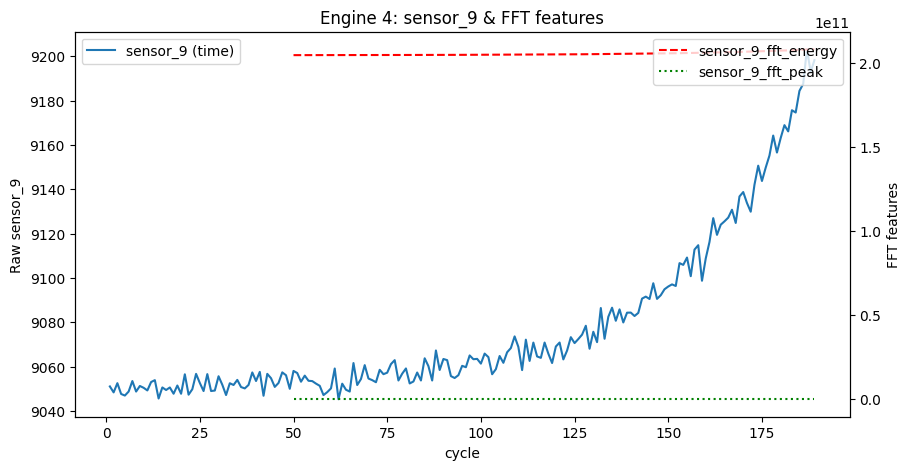

In [ ]:
unit_id = 4  # choose any engine ID that exists in your data
plot_cols = ["sensor_9", "sensor_9_fft_energy", "sensor_9_fft_peak"]

tmp = df[df["unit"] == unit_id].reset_index(drop=True)

ax = tmp.plot(x="cycle", y="sensor_9", label="sensor_9 (time)", figsize=(10,5))
ax2 = ax.twinx()
tmp.plot(x="cycle", y="sensor_9_fft_energy", label="sensor_9_fft_energy", ax=ax2, style='r--')
tmp.plot(x="cycle", y="sensor_9_fft_peak", label="sensor_9_fft_peak", ax=ax2, style='g:')

ax.set_ylabel("Raw sensor_9")
ax2.set_ylabel("FFT features")
ax.set_title(f"Engine {unit_id}: sensor_9 & FFT features")
ax.legend(loc="upper left")
ax2.legend(loc="upper right")

In [ ]:
# Generate graphs for multiple engines